# Fine-Tuning BERT on the IMDB Dataset 🎬 for Sentiment Analysis 😊📉

Le dataset IMDB est une ressource populaire pour les projets d'apprentissage automatique, surtout en **traitement du langage naturel (NLP)** 🧠. Il contient des **commentaires de films** 📝 et leurs **annotations en termes de sentiments** 😊😠 (positif ou négatif).



Ce dataset est souvent utilisé pour des tâches de **classification de sentiments** grâce aux critiques et aux avis des utilisateurs.



## Caractéristiques principales 🌟:



**Taille** : Il comprend environ **50 000 critiques** de films en anglais, divisées en **25 000 pour l'entraînement** et **25 000 pour les tests**. 🧪\



**Annotations de sentiments** : Chaque critique est étiquetée soit **positive** (+) soit **négative** (-), permettant ainsi un apprentissage supervisé pour des modèles de **machine learning** 🖥️.



**Source** : Les données proviennent du site **IMDB**, une référence mondiale dans le domaine des films, séries et autres contenus 🎥🌐.



**Nettoyage** : Les critiques contiennent du **texte brut**, sans nettoyage pré-établi, ce qui laisse une **grande flexibilité pour le prétraitement des données** 🛠️.



Ce dataset est particulièrement utile pour ceux qui veulent développer des modèles capables d'analyser et de **prédire** les **sentiments** exprimés dans les textes.

# Importation des bibliothèques 📚

 Pour commencer, nous allons importer toutes les bibliothèques nécessaires pour ce projet.

In [84]:
!pip install datasets

In [85]:
!pip install torch

In [86]:
!pip install nltk

In [87]:
import torch

import transformers

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

from datasets import load_dataset

from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import re

import nltk

import zipfile

import os

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

from wordcloud import WordCloud


In [88]:
nltk.download('stopwords', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('omw-1.4', download_dir='/root/nltk_data')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [89]:
print(nltk.data.path)

['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', './nltk_data']


In [90]:
from nltk.corpus import wordnet

In [91]:
# Définir un répertoire local pour nltk_data
local_nltk_data_path = './nltk_data'

# Créer le répertoire s'il n'existe pas
os.makedirs(local_nltk_data_path, exist_ok=True)

# Télécharger le corpus WordNet dans le répertoire local
nltk.download('wordnet', download_dir=local_nltk_data_path)
nltk.download('omw-1.4', download_dir=local_nltk_data_path)

# Chemin vers le fichier .zip de WordNet
wordnet_zip_path = os.path.join(local_nltk_data_path, 'corpora', 'wordnet.zip')

# Vérifiez si le fichier est bien téléchargé
if os.path.exists(wordnet_zip_path):
    # Décompresser le fichier .zip dans le même répertoire
    with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(local_nltk_data_path, 'corpora'))
    print("Le fichier WordNet a été décompressé avec succès.")
else:
    print("Le fichier .zip de WordNet n'a pas été trouvé.")

# Ajouter le répertoire local à nltk.data.path
nltk.data.path.append(local_nltk_data_path)

# Vérifier si WordNet est maintenant disponible
try:
    from nltk.corpus import wordnet
    synsets = wordnet.synsets("dog")
    print("WordNet est accessible. Exemple de synsets :", synsets)
except LookupError:
    print("WordNet n'est pas disponible même après décompression.")


[nltk_data] Downloading package wordnet to ./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Le fichier WordNet a été décompressé avec succès.
WordNet est accessible. Exemple de synsets : [Synset('dog.n.01'), Synset('frump.n.01'), Synset('dog.n.03'), Synset('cad.n.01'), Synset('frank.n.02'), Synset('pawl.n.01'), Synset('andiron.n.01'), Synset('chase.v.01')]


#Charger le dataset IMDB 🎬

Maintenant que les bibliothèques sont importées, nous allons charger le dataset IMDB pour l'analyse des sentiments.


In [92]:
dataset = load_dataset("imdb")

Affichones les premières lignes du dataset IMDB, cela nous donnera une idée du format et du contenu des données.

In [93]:
# Afficher des informations sur le dataset

print("\nInformations sur le dataset IMDB :")

print(dataset)


Informations sur le dataset IMDB :
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [94]:
# Afficher les premières lignes du dataset

print("Les premières lignes du dataset IMDB :")

print(dataset['train'][0])

Les premières lignes du dataset IMDB :
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the s

## Visualisation des données initiales 📊

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


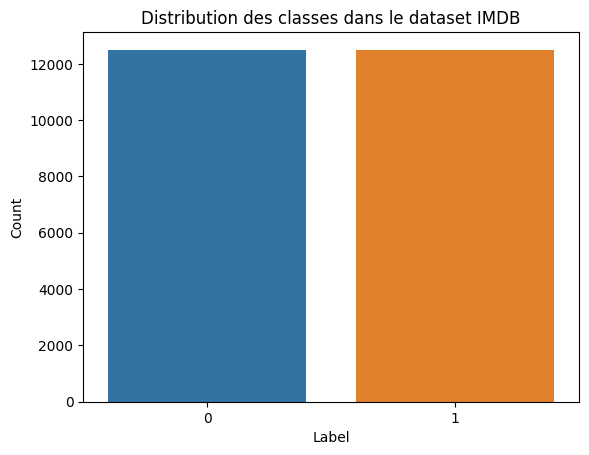

In [95]:
# Fonction pour visualiser la distribution des classes (positives/négatives) dans le dataset IMDB

def visualize_initial_data(dataset):

    labels = [example['label'] for example in dataset['train']]

    sns.countplot(x=labels)

    plt.xlabel('Label')

    plt.ylabel('Count')

    plt.title('Distribution des classes dans le dataset IMDB')

    plt.show()



# Appeler la fonction pour visualiser la data

visualize_initial_data(dataset)



D'après les Boxplots obtenus ci-dessus 📊, les données semblent bien équilibrées ⚖️, avec une répartition équitable entre les deux labels (0 pour les sentiments négatifs 😠 et 1 pour les sentiments positifs 😊). Cela signifie qu'il n'est probablement pas nécessaire d'appliquer des techniques de rééquilibrage des classes telles que le sous-échantillonnage (undersampling) 🔽 ou le sur-échantillonnage (oversampling) 🔼 pour corriger un éventuel déséquilibre.



💡 Cette répartition équilibrée peut donc favoriser une meilleure performance des modèles de classification 🤖 en réduisant les biais potentiels vers une classe spécifique.

## Visualisation des nuages de mots (Word Cloud) ☁️



Passons à une visualisation amusante ! Nous allons générer un nuage de mots pour voir **les termes les plus fréquents** dans **les critiques**.


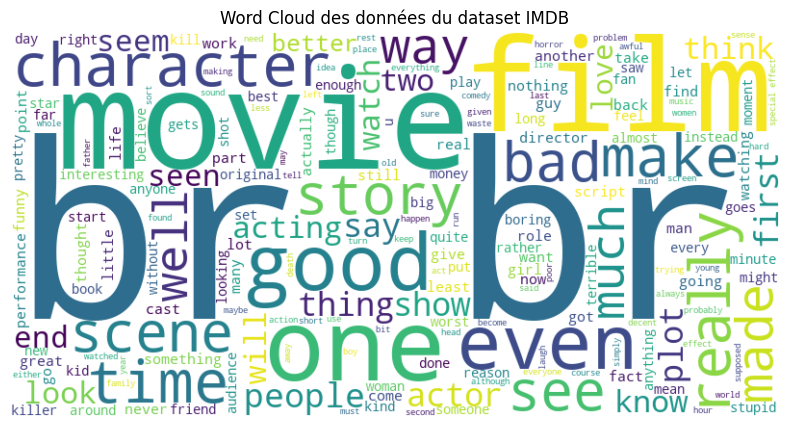

In [96]:
# Génération d'un nuage de mots pour voir les termes les plus fréquents dans les critiques du dataset IMDB.

def visualize_word_cloud(dataset):

    text = ' '.join([example['text'] for example in dataset['train'].select(range(1000))])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))

    plt.imshow(wordcloud, interpolation='bilinear')

    plt.axis('off')

    plt.title('Word Cloud des données du dataset IMDB')

    plt.show()



visualize_word_cloud(dataset)

## Prétraitement des données: Stop word removal (enlever les mots inutiles ❌), lemmatization, etc.



Le prétraitement est essentiel pour nettoyer les textes et améliorer la qualité des données d'entrée.



N.B ❗:

La **lemmatization** consiste à réduire chaque mot à sa forme de base ou "lemme" en utilisant des règles linguistiques.\

Par exemple :

*   **running** devient **run**

*   **children** devient **child**

*   **better** devient **good**



La lemmatization diffère de la stemming, qui coupe simplement la fin des mots sans forcément obtenir des mots complets et corrects.



La lemmatization, en revanche, utilise un dictionnaire pour trouver la forme de base correcte, ce qui la rend plus précise et adaptée aux analyses sémantiques.

In [97]:
# Fonction de prétraitement pour nettoyer le texte en enlevant les balises HTML, les caractères spéciaux, et en appliquant la lemmatisation.

def preprocess_text(text):

    # Conversion en minuscules

    text = text.lower()

    # Enlever les caractères spéciaux et les chiffres

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Enlever les espaces supplémentaires

    text = re.sub(r'\s+', ' ', text).strip()

    # Enlever les balises HTML (si présentes)

    text = re.sub(r'<.*?>', '', text)

    # Enlever les mots de faible importance (stop words)

    stop_words = set(stopwords.words('english'))

    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lemmatisation

    lemmatizer = WordNetLemmatizer()

    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

## Visualisation d'un exemple de texte avant et après pré-traitement 🔍



Jetons un œil à l'effet du prétraitement sur un exemple de texte avant de continuer.


In [98]:
#Affichage d'un exemple de texte avant et après le prétraitement pour visualiser les effets de ce dernier.

original_text = dataset['train'][0]['text']

preprocessed_text = preprocess_text(original_text)

print("Exemple de texte avant pré-traitement :")

print(original_text)

print("\nExemple de texte après pré-traitement :")

print(preprocessed_text)

Exemple de texte avant pré-traitement :
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nu

## Tokenisation des données 📝

### Maintenant que nous avons prétraité nos textes, passons à la tokenisation avec le tokenizer BERT.


**Charger le tokenizer BERT 🔄**



Pour préparer nos données à l'entraînement, nous devons les tokeniser. Nous allons utiliser le tokenizer BERT.


In [99]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Le modèle **BERT base uncased** ne prend pas en compte les différences entre majuscules et minuscules. \

Cela signifie que le tokenizer convertit **tous les caractères** en **minuscules** avant de les traiter.

 Par conséquent, **Hello, HELLO**, et **hello** seront tous tokenisés de la **même manière**.



N.B❗:  L'approche *uncased* est souvent utilisée lorsque la casse (majuscules/minuscules) n'a pas d'importance dans le contexte d'analyse, comme pour des *tâches de classification* de texte général, car cela réduit le nombre de tokens différents et améliore la généralisation.

Maintenant on va tokeniser les textes prétraités en utilisant le tokenizer BERT précédemment initialisé 👍

In [100]:
def tokenize_function(examples):

    examples["text"] = [preprocess_text(text) for text in examples["text"]]

    return tokenizer(examples["text"], padding="max_length", truncation=True)



tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [101]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})


## Visualisation de la longueur des tokens après tokenisation 📏

Voyons la distribution des longueurs des séquences après la tokenisation.


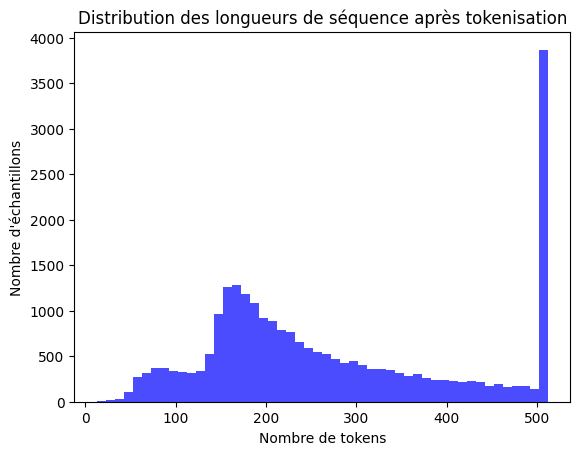

In [102]:
#Fonction pour visualiser la distribution des longueurs des séquences après la tokenisation.

def visualize_token_lengths(tokenized_datasets):

    lengths = [len(tokenizer.encode(example['text'], truncation=True)) for example in dataset['train']]

    plt.hist(lengths, bins=50, color='blue', alpha=0.7)

    plt.xlabel('Nombre de tokens')

    plt.ylabel("Nombre d'échantillons")

    plt.title('Distribution des longueurs de séquence après tokenisation')

    plt.show()



visualize_token_lengths(dataset)

# BERT pour la classification de séquences 🤖

## Il est temps de charger notre modèle BERT pré-entraîné pour l'analyse des sentiments.


In [103]:
# Chargement du modèle BERT pré-entraîné pour la classification des séquences en deux classes (positif/négatif).

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
# Préparer les DataLoaders pour l'entraînement et la validation

train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True)

eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

# FINETUNING de BERT ⚙️

##Définir les arguments d'entraînement ⚡



Détails des paramètres de TrainingArguments ⁉



**output_dir** : Spécifie le répertoire où les résultats de l’entraînement (comme les checkpoints du modèle) seront sauvegardés. Ici, c'est ./results.



**evaluation_strategy** : Définit la fréquence d’évaluation du modèle. "epoch" signifie que le modèle sera évalué à la fin de chaque époque (c’est-à-dire après que toutes les données d’entraînement ont été traitées une fois).



**learning_rate** : Le taux d'apprentissage, ici défini à 2e-5. Ce paramètre contrôle la vitesse à laquelle le modèle ajuste ses poids pendant l’entraînement. Une valeur trop élevée peut entraîner une divergence, tandis qu’une valeur trop basse peut ralentir l’entraînement.



**per_device_train_batch_size** : Taille du lot d’entraînement par appareil (GPU ou CPU). Ici, le modèle utilisera 8 exemples par lot lors de l’entraînement.



**per_device_eval_batch_size** : Taille du lot d'évaluation par appareil. Ici, il est également de 8, ce qui signifie que le modèle traitera 8 exemples à la fois lors de l’évaluation.



**num_train_epochs** : Nombre d’époques, soit le nombre de fois où le modèle verra l’intégralité des données d’entraînement. Ici, il est défini sur 3, donc le modèle passera trois fois sur le jeu de données.



**weight_decay** : Taux de décroissance des poids (weight decay), fixé ici à 0.01. C’est une technique de régularisation qui réduit les valeurs des poids pour éviter le surapprentissage (overfitting).



**logging_dir** : Chemin pour sauvegarder les logs, ici ./logs. Ces logs incluent des informations de suivi pour l’entraînement, comme la perte et la précision.



**logging_steps** : Fréquence de journalisation pendant l’entraînement. Ici, des informations seront enregistrées tous les 10 pas (steps), fournissant des mises à jour régulières sur la progression de l’entraînement.




In [110]:
#Définissons les paramètres pour l'entraînement de notre modèle, tels que le taux d'apprentissage et la taille des lots.

training_args = TrainingArguments(

    output_dir="./results",

    evaluation_strategy="epoch",  # évaluation à chaque époque

    save_strategy="epoch",  # sauvegarde du modèle à chaque époque

    save_total_limit=2,  # nombre max de checkpoints sauvegardés pour éviter l'accumulation

    learning_rate=2e-5,

    per_device_train_batch_size=8,

    per_device_eval_batch_size=8,

    num_train_epochs=3,

    weight_decay=0.01, #Cela indiquera au formateur d'appliquer une perte de poids lors de l'utilisation d'AdamW.

    logging_dir='./logs',

    logging_steps=10,

    load_best_model_at_end=True,

)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


##Définir les fonctions de précision 🎯

In [111]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred

    # Convert logits to a PyTorch tensor

    logits = torch.from_numpy(logits)

    predictions = torch.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    acc = accuracy_score(labels, predictions)

    return {

        'accuracy': acc,

        'f1': f1,

        'precision': precision,

        'recall': recall

    }

##Créer l'objet Trainer 🏋️‍♂️

Le code ci-dessus crée un **objet Trainer** de la bibliothèque **Hugging Face**, qui simplifie et organise le processus d'entraînement (**ou fine-tuning**) d'un modèle.





Explication des paramètres du Trainer :



*   model=model : Le modèle BERT (ou un

autre modèle pré-entraîné) que vous souhaitez fine-tuner sur votre jeu de données. Ce modèle a été initialisé et chargé plus tôt dans le code.



*   args=training_args : Les paramètres d’entraînement définis précédemment avec TrainingArguments, qui incluent des détails comme le taux d’apprentissage, la taille des lots, le nombre d’époques, le répertoire de sortie, etc.



*   train_dataset=tokenized_datasets["train"] : Le jeu de données d'entraînement. Il doit être tokenisé (prêt pour le modèle) et est spécifié ici pour que le Trainer sache quelles données utiliser lors de l'entraînement.



*   eval_dataset=tokenized_datasets["test"] : Le jeu de données d'évaluation. Cela permet au Trainer d'évaluer le modèle périodiquement (par exemple, à chaque fin d'époque) pour suivre les performances sur des données que le modèle n’a pas encore vues. Cela aide à prévenir le surapprentissage (overfitting).



*   compute_metrics=compute_metrics : Une fonction personnalisée qui calcule des métriques d’évaluation (comme l’exactitude, la précision, le rappel, le F1-score, etc.). Le Trainer utilise cette fonction pour afficher des informations de performance après chaque évaluation.

In [112]:
# Créons maintenant l'objet Trainer qui nous aidera à entraîner notre modèle.

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized_datasets["train"],

    eval_dataset=tokenized_datasets["test"],

    compute_metrics=compute_metrics,

    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Arrête après 3 périodes sans amélioration

)

#Entraînement du modèle 🚀

In [114]:
#Passons à l'entraînement du modèle sur notre jeu de données prétraité et tokenisé.

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.202400,0.234773,0.908480,0.908098,0.911907,0.904320
2,0.143200,0.286651,0.908960,0.907517,0.922130,0.893360
3,0.150500,0.376581,0.911720,0.912777,0.901976,0.923840


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=4689, training_loss=0.193585661361278, metrics={'train_runtime': 5392.7927, 'train_samples_per_second': 13.907, 'train_steps_per_second': 0.869, 'total_flos': 1.9733329152e+16, 'train_loss': 0.193585661361278, 'epoch': 3.0})

# Évaluation du modèle 📊

In [117]:
# Une fois l'entraînement terminé, évaluons la performance de notre modèle.

trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.23477332293987274,
 'eval_accuracy': 0.90848,
 'eval_f1': 0.9080976863753213,
 'eval_precision': 0.9119070667957405,
 'eval_recall': 0.90432,
 'eval_runtime': 448.0835,
 'eval_samples_per_second': 55.793,
 'eval_steps_per_second': 3.488,
 'epoch': 3.0}

### Visualisation des métriques d'évaluation 📈

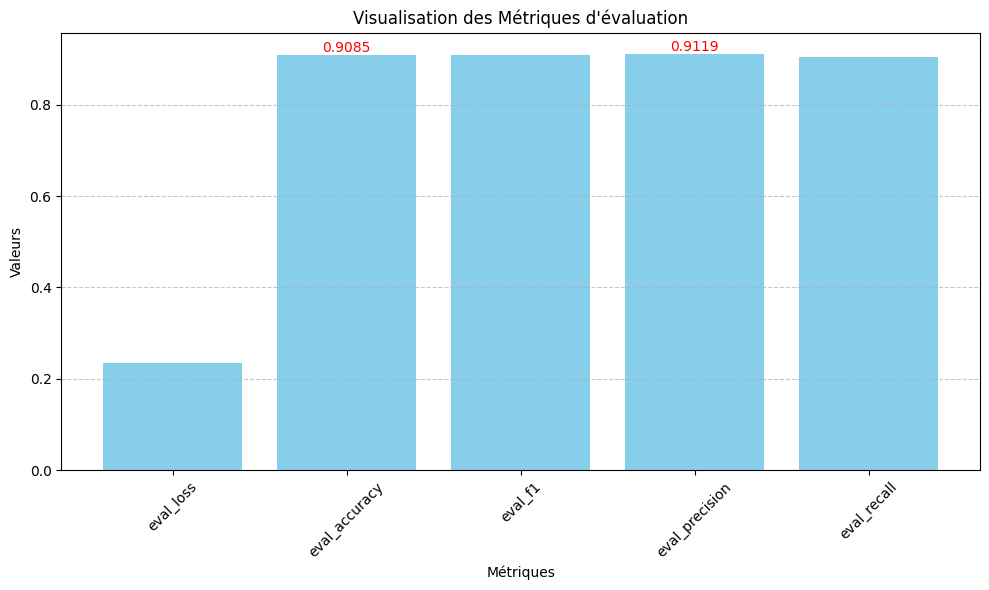

In [7]:
# Fonction pour évaluer et visualiser les métriques
def evaluate_and_visualize(trainer):
    # Obtenir les métriques à partir de trainer.evaluate()
    metrics = trainer.evaluate()

    # Sélection des métriques à visualiser
    metrics_to_plot = {k: v for k, v in metrics.items() if k not in ['eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch']}

    # Création du graphique
    plt.figure(figsize=(10, 6))
    plt.bar(metrics_to_plot.keys(), metrics_to_plot.values(), color='skyblue')
    plt.xlabel('Métriques')
    plt.ylabel('Valeurs')
    plt.title("Visualisation des Métriques d'évaluation")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajout de la valeur exacte de precision
    if 'eval_precision' in metrics:
        precision_value = metrics['eval_precision']
        plt.text('eval_precision', precision_value, f'{precision_value:.4f}', color='red', ha='center', va='bottom')

    # Ajout de la valeur exacte de accuracy
    if 'eval_accuracy' in metrics:
        accuracy_value = metrics['eval_accuracy']
        plt.text('eval_accuracy', accuracy_value, f'{accuracy_value:.4f}', color='red', ha='center', va='bottom')

    # Affichage du graphique
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
   evaluate_and_visualize(trainer)


Les **résultats** de ce **fine-tuning de BERT** sur le dataset **IMDB** sont tout simplement remarquables 🎉 ! Voici les points forts de l'évaluation :

1. **Accuracy** : Avec une précision de **0.9085**, cela montre que le modèle a appris efficacement à distinguer les sentiments des critiques de films, atteignant plus de 90% de bonnes classifications 👍.
   
2. **F1 Score** : Le score F1 de **0.9081** est excellent 🤩, ce qui indique un équilibre optimal entre la précision et le rappel. Cela signifie que le modèle est non seulement précis, mais également cohérent dans ses prédictions.
   
3. **Précision** (Precision) : La valeur de précision est de **0.9119**, ce qui est fantastique 🎯! Cela montre que lorsque le modèle prédit une classe, il est très souvent correct. Une très bonne nouvelle pour minimiser les faux positifs !

4. **Rappel (Recall)** : Un rappel de **0.9043** prouve que le modèle détecte la majorité des exemples pertinents 🚀. Cela permet de s’assurer que peu d’exemples sont laissés de côté, ce qui est crucial pour un bon modèle de classification.
5. 
Ces résultats montrent une **excellente capacité de généralisation du modèle** après le fine-tuning 📈👏.
